# Chapter5. 순환 신경망(RNN)

**피드포워드**: 흐름이 단방향인 신경망 -> 시계열 데이터의 성질을 충분히 학습할 수 없음 -> **순환신경망(RNN)** 등장


In [2]:
from IPython.display import Image
import numpy as np

## 5.1 확률과 언어모델

### 5.1.1 word2vec을 확률 관점에서 바라보다

CBOW 모델의 본래 목적인 '맥락으로부터 타깃을 추측하는 것'은 어디에 이용할까?  -> **'언어모델'**

### 5.1.2 언어모델

- 단어 나열에 확률을 부여
- 특정한 단어의 시퀀스에 대해서 그 시퀀스가 일어날 가능성이 어느 정도인지 출력
- 새로운 모델 생성 가능

**단어 시퀀스를 하나씩 줄여가면서 매번 사후 확률로 분해한 결과**

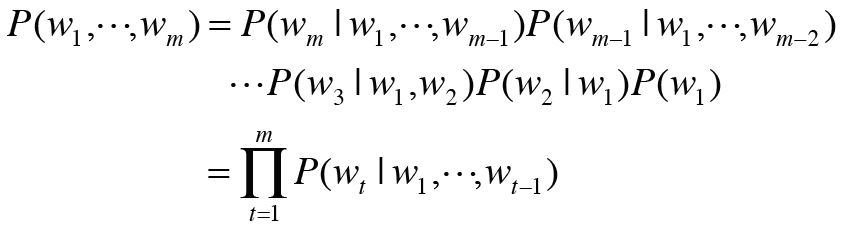

In [3]:
Image("image/e 5-4.png")

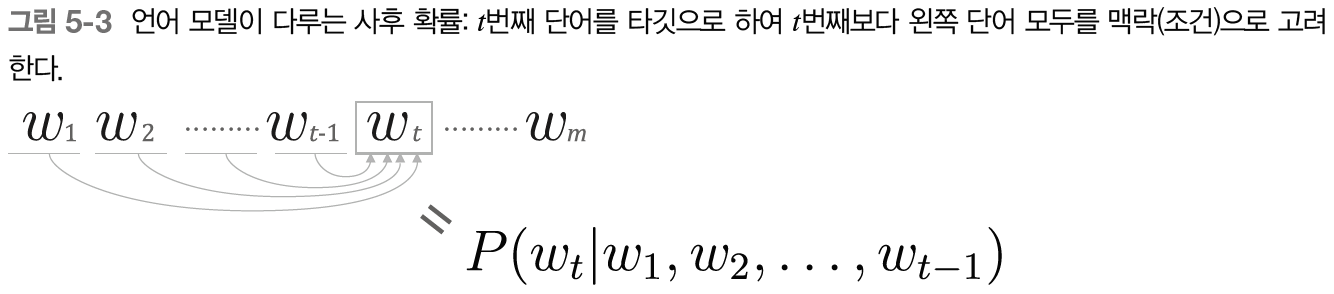

In [4]:
Image("image/fig 5-3.png")

### 5.1.3 CBOW 모델을 언어 모델로?

맥락을 왼쪽 두 개의 단어로 한정한다 했을 때

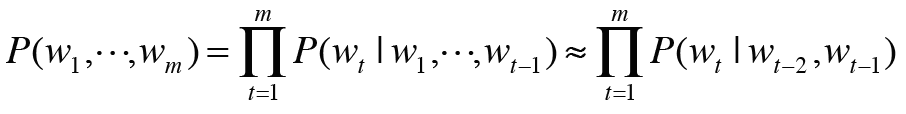

In [5]:
Image("image/e 5-8.png")

**하지만 문제가 되는 경우는 다음과 같음**

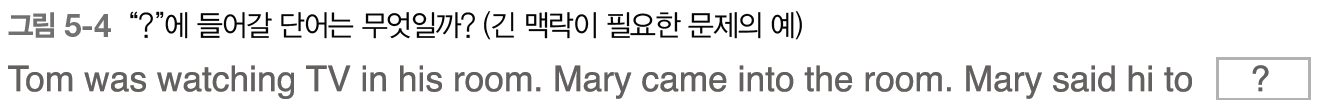

In [6]:
Image("image/fig 5-4.png")

물음표에 들어갈 말을 구하려면 18번째나 앞에 나오는 'Tom'을 기억해야 하는데 CBOW의 맥락이 10개까지였다면 제대로 답할 수 없음!

## 5.2 RNN이란

### 5.2.1 순환하는 신경망

'닫힌 경로' 또는 '순환하는 경로'가 존재해야 데이터가 같은 장소를 반복해 왕래할 수 있음

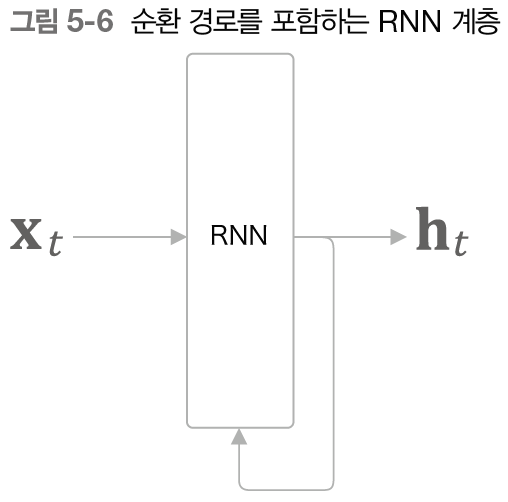

In [7]:
Image("image/fig 5-6.png")

출력이 두개로 **분기**(같은 것이 복제되어 분리됨)하는 것을 볼 수 있음

### 5.2.2 순환 구조 펼치기

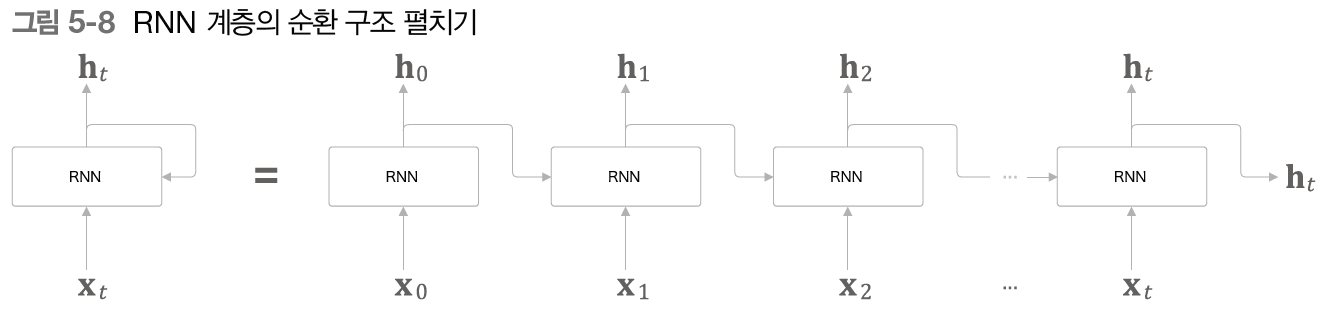

In [8]:
Image("image/fig 5-8.png")

피드포워드와 같아 보이지만 반복되는 RNN 계층 모두가 실제로는 같은계층!

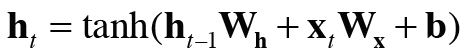

In [9]:
Image("image/e 5-9.png")

- Wx: 입력 x를 출력 h로 변환하기 위한 가중치
- Wh: RNN 출력을 다음 시각의 출력으로 변환하기 위한 가중치
- ht는 다른 계층을 향해 위쪽으로 출력되는 동시에 다음 시각의 RNN 계층을 향해 오른쪽으로도 출력
- h(은닉상태)는 상태를 가지고 있음 -> RNN 계층을 '상태(메모리)를 가지는 계층'이라고 함

### 5.2.3 BPTT

시간 방향으로 펼친 신경망의 오차역전파법

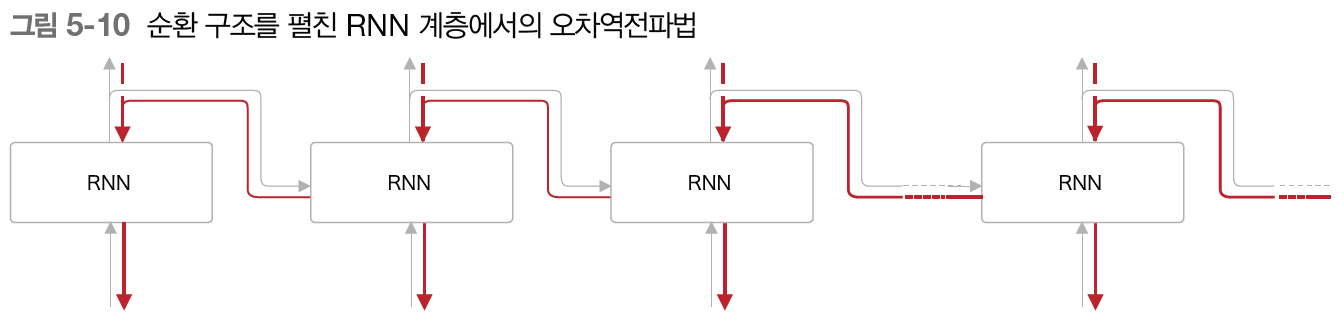

In [10]:
Image("image/fig 5-10.png")

시계열 데이터의 시간 크기가 커지는 것에 비례하여 BPTT가 소비하는 컴퓨팅 자원이 증가한다는 문제 발생


### 5.2.4 Truncated BPTT

- 시간축 방향으로 너무 길어진 신경망을 적당한 지점에서 잘라내어 작은 신경망 여러개로 만든다는 아이디어
- 단, 순전파의 연결은 유지하고 역전파의 연결만 끊어야 함

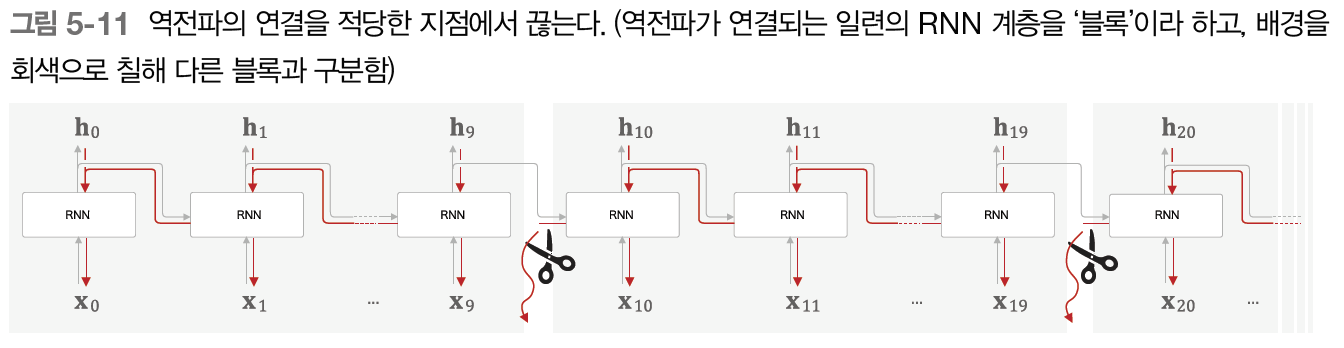

In [11]:
Image("image/fig 5-11.png")

- 역전파의 연결을 잘라버리면 그보다 미래의 데이터에 대해서는 생각할 필요가 X
- 미래의 블록과는 독립적으로 오차역전파법을 완결시킬 수 있음
- 순전파 연결은 끊어지지 않았기 때문에 데이터를 순서대로 입력해야하는 것은 마찬가지!

### 5.2.5 Truncated BPTT의 미니배치 학습

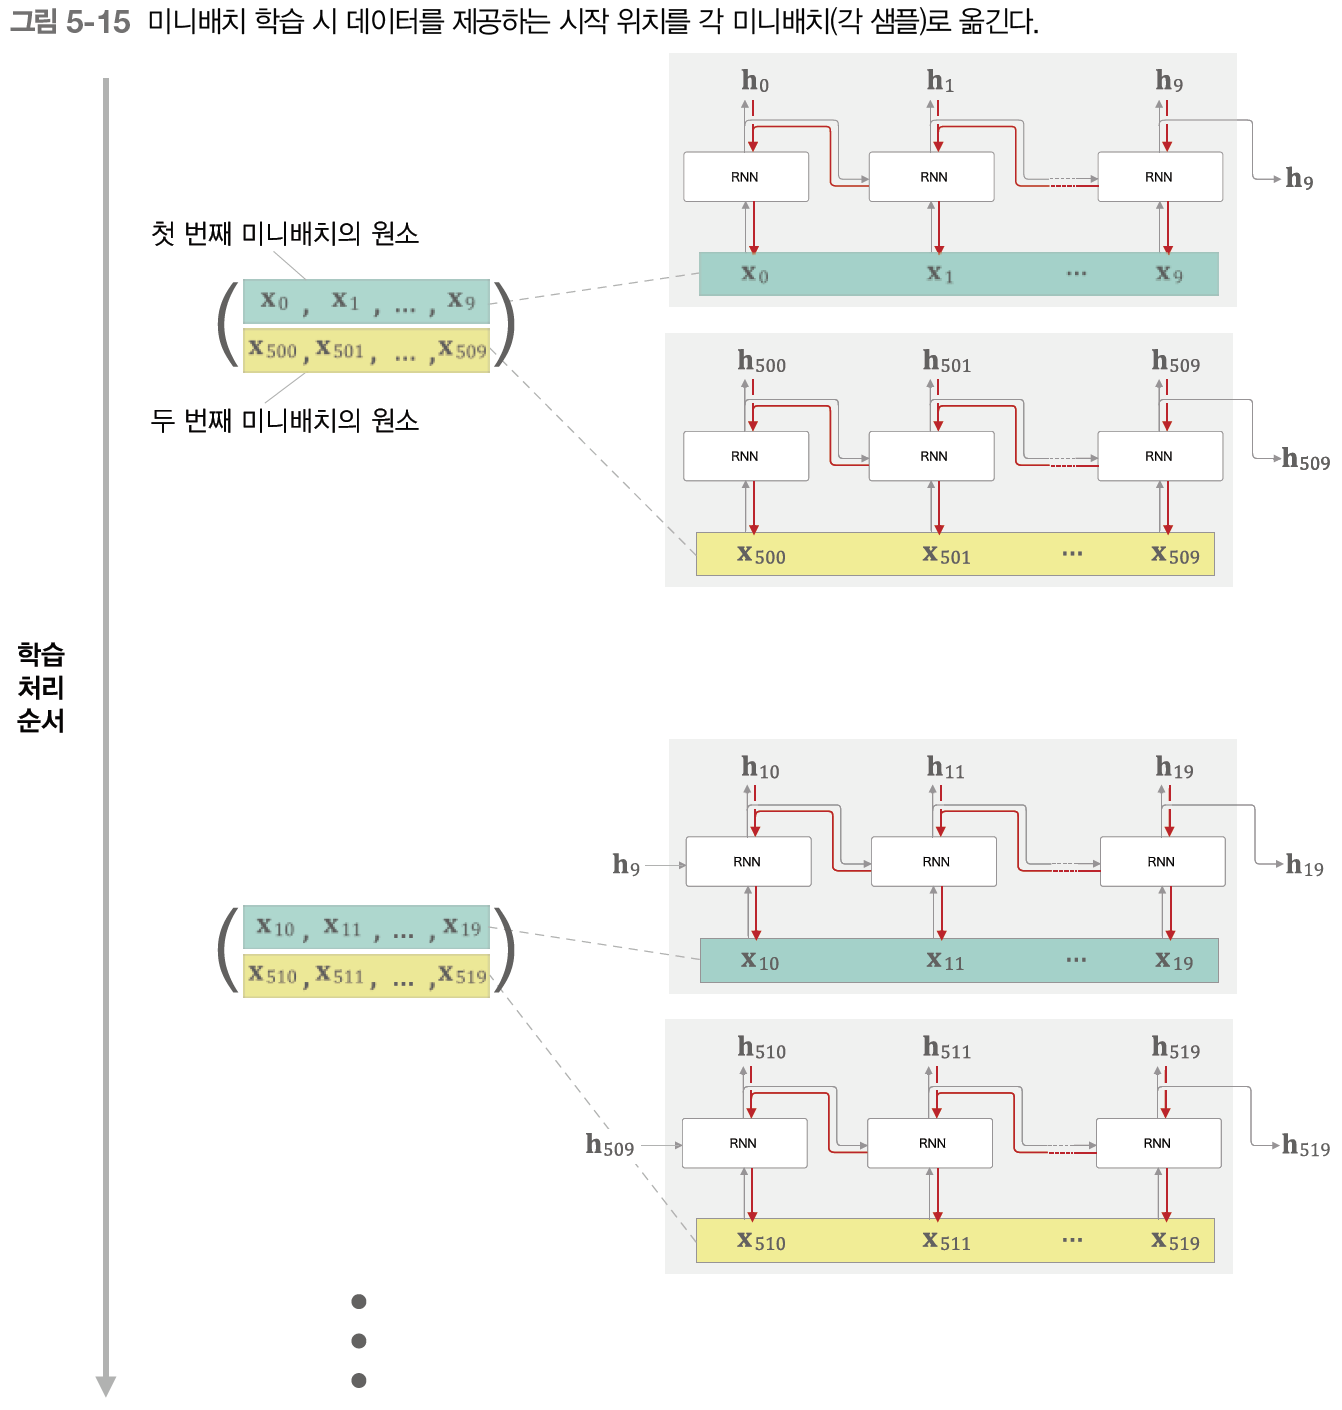

In [12]:
Image("image/fig 5-15.png")

## 5.3 RNN 구현

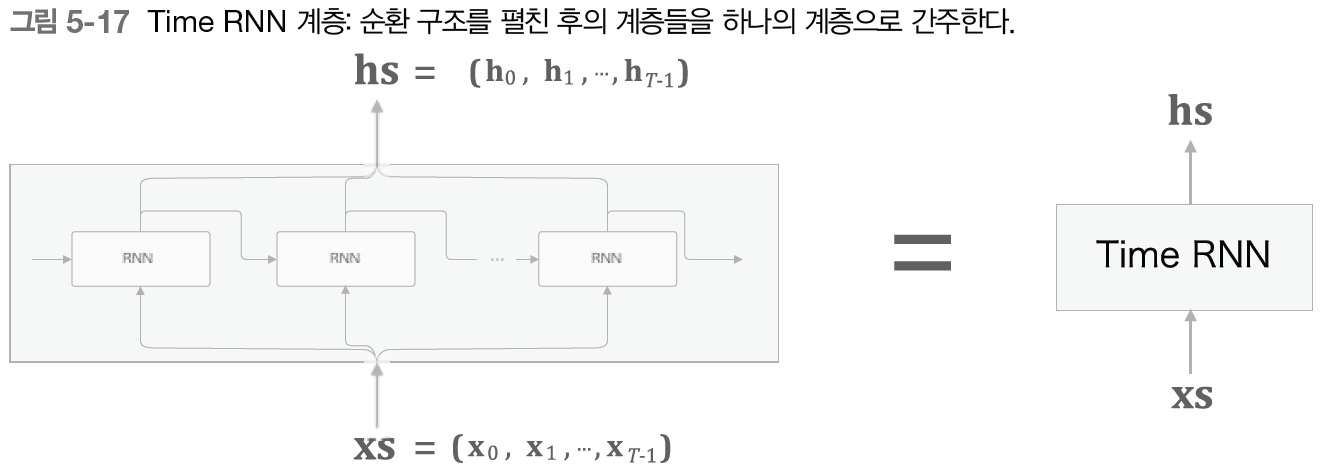

In [13]:
Image("image/fig 5-17.png")

### 5.3.1 RNN 계층 구현

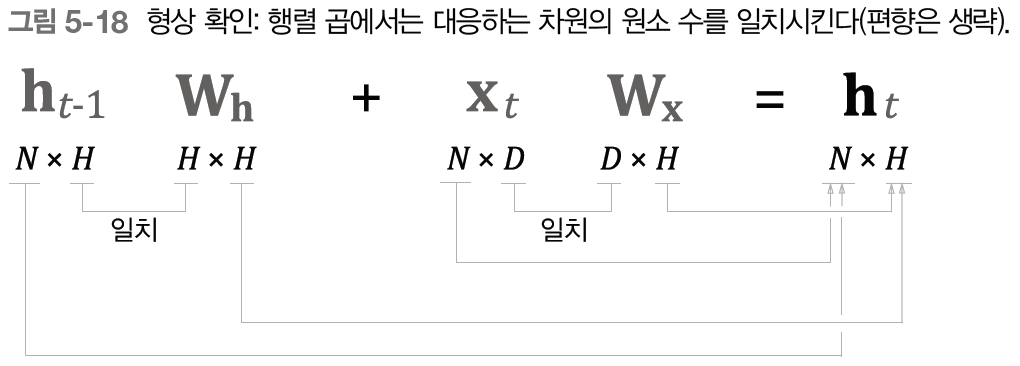

In [14]:
Image("image/fig 5-18.png")

In [15]:
class RNN:
    
    
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None

        
    def forward(self, x, h_prev):
        Wx, Wh, b = self.params
        t = np.dot(h_prev, Wh) + np.dot(x, Wx) + b
        h_next = np.tanh(t)

        self.cache = (x, h_prev, h_next)
        
        return h_next

    
    def backward(self, dh_next):
        Wx, Wh, b = self.params
        x, h_prev, h_next = self.cache

        dt = dh_next * (1 - h_next ** 2)
        db = np.sum(dt, axis=0)
        dWh = np.dot(h_prev.T, dt)
        dh_prev = np.dot(dt, Wh.T)
        dWx = np.dot(x.T, dt)
        dx = np.dot(dt, Wx.T)

        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        return dx, dh_prev


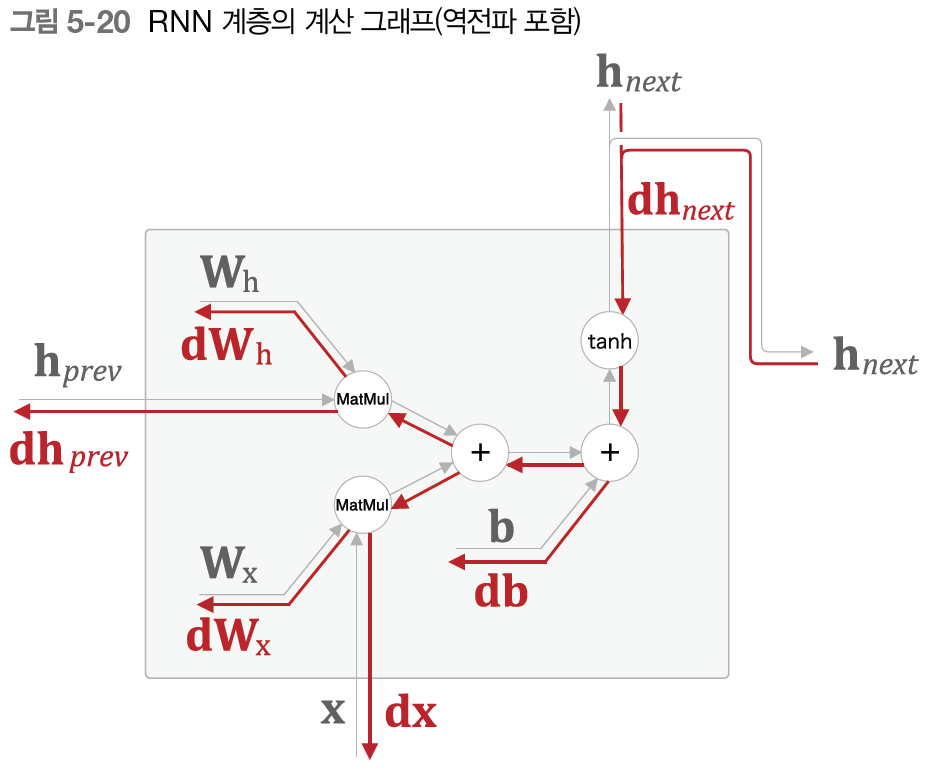

In [16]:
Image("image/fig 5-20.png")

### 5.3.2 Time RNN 계층 구현

Time RNN 계층은 T개의 RNN 계층으로 구성 됨

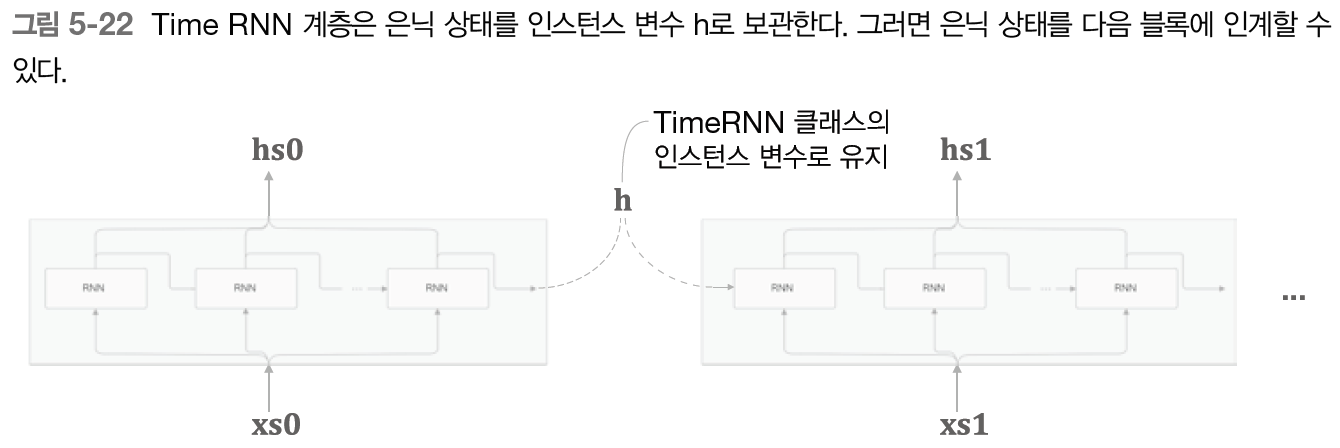

In [17]:
Image("image/fig 5-22.png")

In [18]:
class TimeRNN:
    
    
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None

        self.h, self.dh = None, None
        self.stateful = stateful

        
    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        D, H = Wx.shape

        self.layers = []
        hs = np.empty((N, T, H), dtype='f')

        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')

        for t in range(T):
            layer = RNN(*self.params)
            self.h = layer.forward(xs[:, t, :], self.h)
            hs[:, t, :] = self.h
            self.layers.append(layer)

        return hs

    
    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D, H = Wx.shape

        dxs = np.empty((N, T, D), dtype='f')
        dh = 0
        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh = layer.backward(dhs[:, t, :] + dh)
            dxs[:, t, :] = dx

            for i, grad in enumerate(layer.grads):
                grads[i] += grad

        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh

        return dxs

    
    def set_state(self, h):
        self.h = h

        
    def reset_state(self):
        self.h = None

## 5.4 시계열 데이터 처리 계층 구현

**RNNLM**: RNN Language Model

### 5.4.1 RNNLM의 전체그림

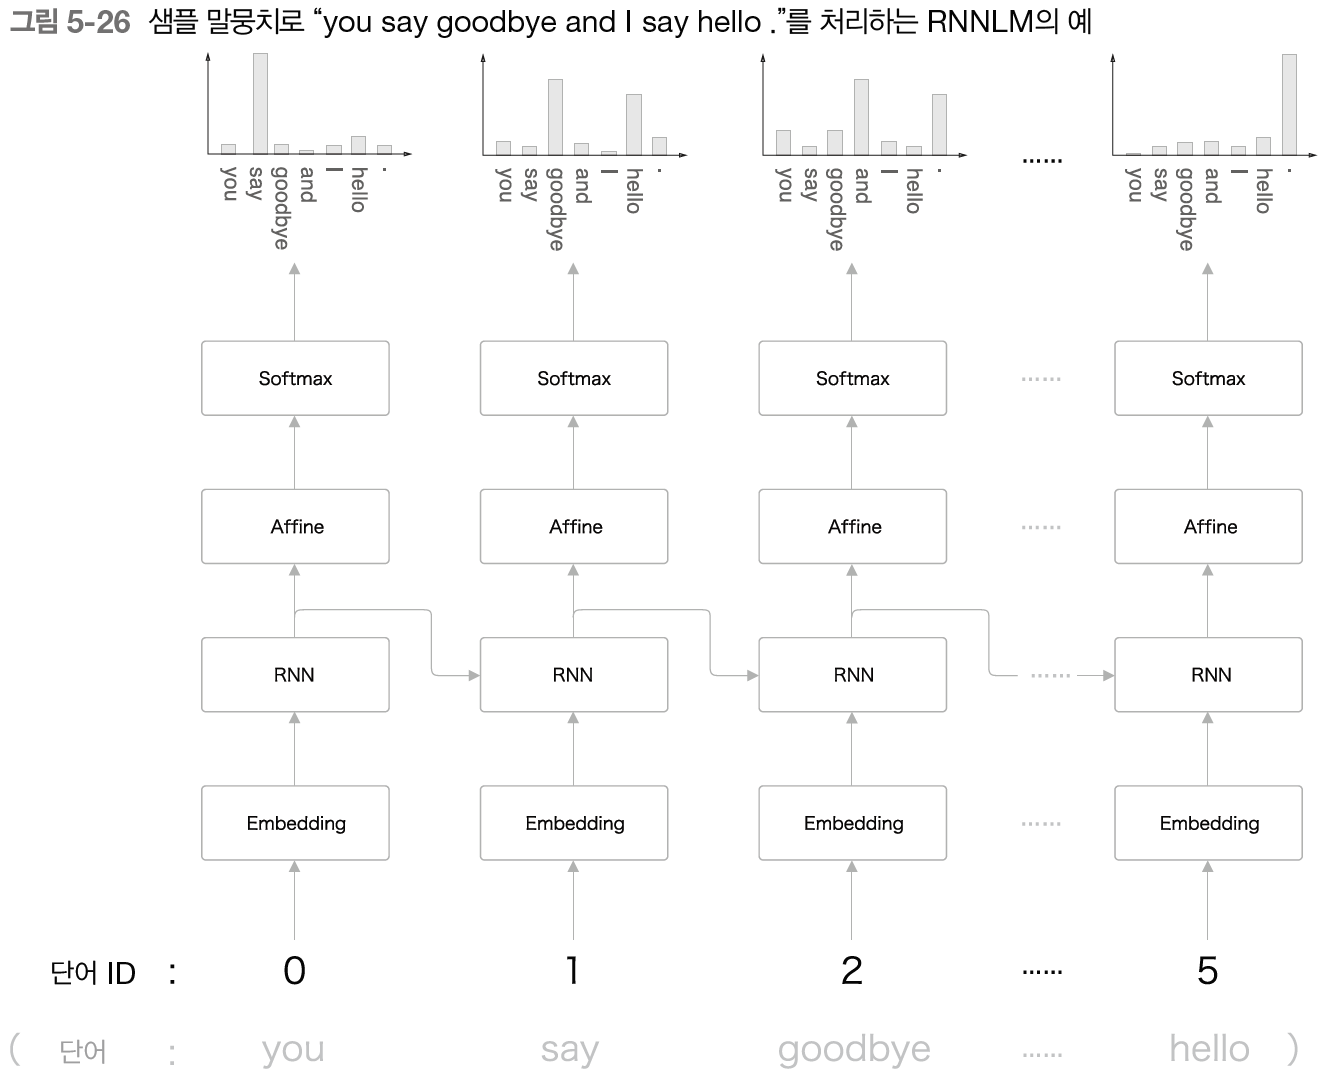

In [20]:
Image("image/fig 5-26.png")

- Embedding 계층: 단어 ID를 단어의 분산표현(벡터)으로 변환
- RNN 계층: 은닉 상태를 다음 층으로 출력함과 동시에 다음 시각의 RNN 계층으로 출력
- RNNLM은 지금까지 입력된 단어를 기억하고 그것을 바탕으로 다음에 출현할 단어를 예측할 수 있음!

### 5.4.2 Time 계층 구현

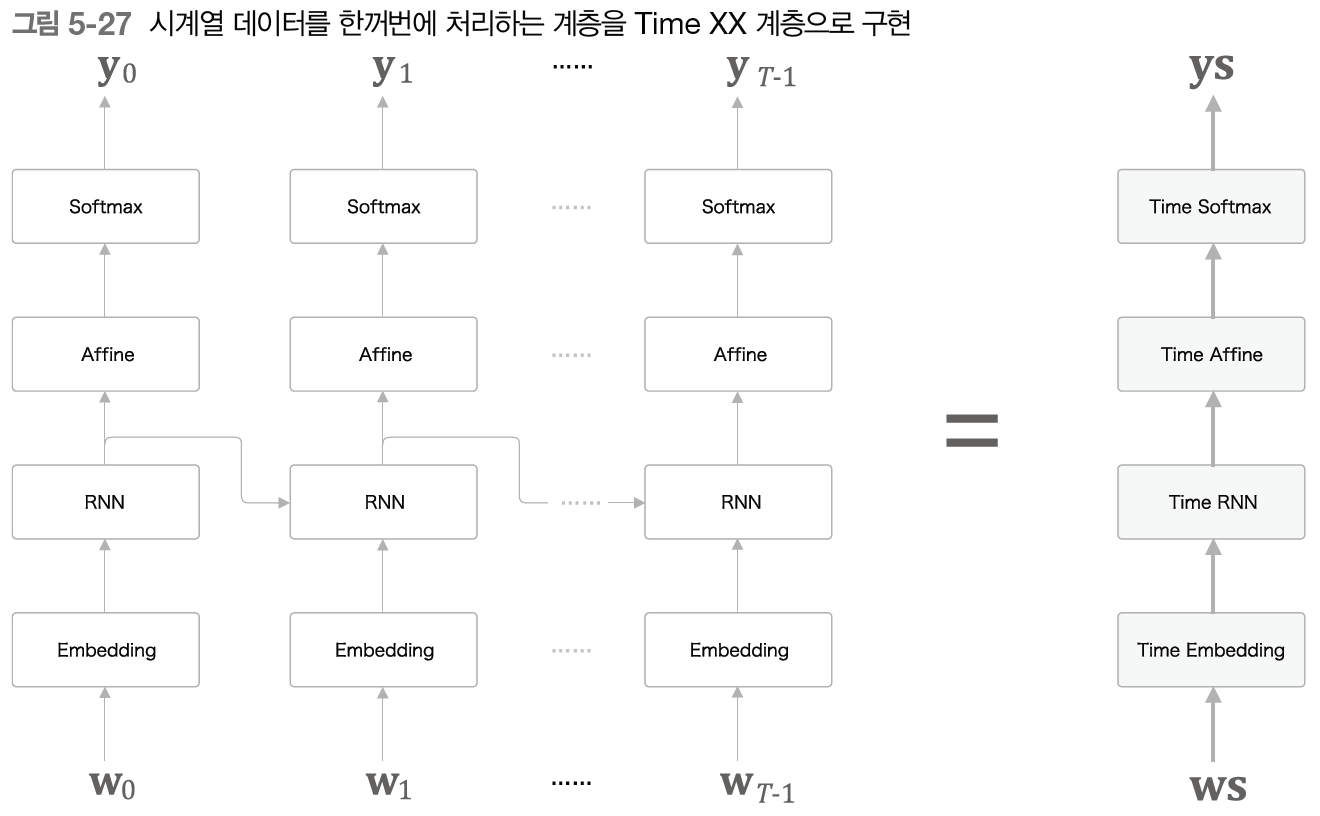

In [24]:
Image("image/fig 5-27.png")

**손실 계산** -> T개 손실들의 평균

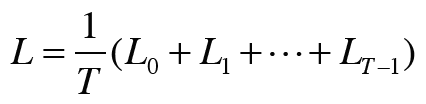

In [26]:
Image("image/e 5-11.png")

## 5.5 RNNLM 학습과 평가

### RNNLM 구현

In [27]:
import sys
sys.path.append('..')
import numpy as np
from common.time_layers import *


class SimpleRnnlm:
    
    
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        # 가중치 초기화
        embed_W = (rn(V, D) / 100).astype('f')
        rnn_Wx = (rn(D, H) / np.sqrt(D)).astype('f')
        rnn_Wh = (rn(H, H) / np.sqrt(H)).astype('f')
        rnn_b = np.zeros(H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        # 계층 생성
        self.layers = [
            TimeEmbedding(embed_W),
            TimeRNN(rnn_Wx, rnn_Wh, rnn_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.rnn_layer = self.layers[1]

        # 모든 가중치와 기울기를 리스트에 모은다.
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, ts):
        for layer in self.layers:
            xs = layer.forward(xs)
        loss = self.loss_layer.forward(xs, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        self.rnn_layer.reset_state()

### 5.5.2 언어 모델의 평가

**퍼플렉서티**: '확률의 역수', 작을수록 좋은 지표

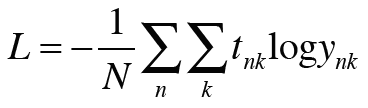

In [28]:
Image("image/e 5-12.png")

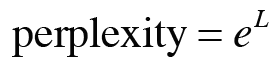

In [29]:
Image("image/e 5-13.png")

### 5.5.3 RNNLM의 학습 코드

말뭉치 크기: 1000, 어휘 수: 418
| 에폭 1 | 퍼플렉서티 379.03
| 에폭 2 | 퍼플렉서티 247.37
| 에폭 3 | 퍼플렉서티 219.75
| 에폭 4 | 퍼플렉서티 213.89
| 에폭 5 | 퍼플렉서티 203.76
| 에폭 6 | 퍼플렉서티 200.77
| 에폭 7 | 퍼플렉서티 197.21
| 에폭 8 | 퍼플렉서티 195.77
| 에폭 9 | 퍼플렉서티 190.80
| 에폭 10 | 퍼플렉서티 192.38
| 에폭 11 | 퍼플렉서티 188.05
| 에폭 12 | 퍼플렉서티 191.42
| 에폭 13 | 퍼플렉서티 189.87
| 에폭 14 | 퍼플렉서티 190.13
| 에폭 15 | 퍼플렉서티 188.54
| 에폭 16 | 퍼플렉서티 185.18
| 에폭 17 | 퍼플렉서티 182.58
| 에폭 18 | 퍼플렉서티 180.07
| 에폭 19 | 퍼플렉서티 182.63
| 에폭 20 | 퍼플렉서티 184.95
| 에폭 21 | 퍼플렉서티 181.78
| 에폭 22 | 퍼플렉서티 176.72
| 에폭 23 | 퍼플렉서티 176.64
| 에폭 24 | 퍼플렉서티 175.74
| 에폭 25 | 퍼플렉서티 174.04
| 에폭 26 | 퍼플렉서티 173.77
| 에폭 27 | 퍼플렉서티 168.42
| 에폭 28 | 퍼플렉서티 164.85
| 에폭 29 | 퍼플렉서티 163.97
| 에폭 30 | 퍼플렉서티 158.18
| 에폭 31 | 퍼플렉서티 162.39
| 에폭 32 | 퍼플렉서티 154.59
| 에폭 33 | 퍼플렉서티 155.59
| 에폭 34 | 퍼플렉서티 150.46
| 에폭 35 | 퍼플렉서티 146.81
| 에폭 36 | 퍼플렉서티 139.76
| 에폭 37 | 퍼플렉서티 137.90
| 에폭 38 | 퍼플렉서티 135.36
| 에폭 39 | 퍼플렉서티 127.47
| 에폭 40 | 퍼플렉서티 123.81
| 에폭 41 | 퍼플렉서티 126.20
| 에폭 42 | 퍼플렉서티 117.82
| 에폭 43 | 퍼플렉서티 111

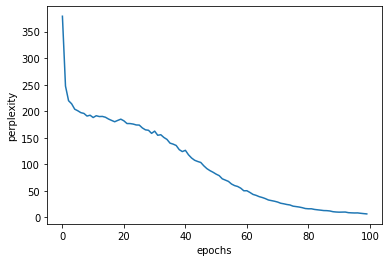

In [32]:
import sys
sys.path.append('..')
import matplotlib.pyplot as plt
import numpy as np
from common.optimizer import SGD
import ptb
#from simple_rnnlm import SimpleRnnlm


# 하이퍼파라미터 설정
batch_size = 10
wordvec_size = 100
hidden_size = 100 # RNN의 은닉 상태 벡터의 원소 수
time_size = 5     # Truncated BPTT가 한 번에 펼치는 시간 크기
lr = 0.1
max_epoch = 100

# 학습 데이터 읽기(전체 중 1000개만)
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)

xs = corpus[:-1]  # 입력
ts = corpus[1:]   # 출력(정답 레이블)
data_size = len(xs)
print('말뭉치 크기: %d, 어휘 수: %d' % (corpus_size, vocab_size))

# 학습 시 사용하는 변수
max_iters = data_size // (batch_size * time_size)
time_idx = 0
total_loss = 0
loss_count = 0
ppl_list = []

# 모델 생성
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)

# 미니배치의 각 샘플의 읽기 시작 위치를 계산
jump = (corpus_size - 1) // batch_size
offsets = [i * jump for i in range(batch_size)]

for epoch in range(max_epoch):
    for iter in range(max_iters):
        # 미니배치 취득
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, t] = xs[(offset + time_idx) % data_size]
                batch_t[i, t] = ts[(offset + time_idx) % data_size]
            time_idx += 1

        # 기울기를 구하여 매개변수 갱신
        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)
        total_loss += loss
        loss_count += 1

    # 에폭마다 퍼플렉서티 평가
    ppl = np.exp(total_loss / loss_count)
    print('| 에폭 %d | 퍼플렉서티 %.2f'
          % (epoch+1, ppl))
    ppl_list.append(float(ppl))
    total_loss, loss_count = 0, 0

# 그래프 그리기
x = np.arange(len(ppl_list))
plt.plot(x, ppl_list, label='train')
plt.xlabel('epochs')
plt.ylabel('perplexity')
plt.show()

### 5.5.4 RNNLM의 Trainer 클래스

미니배치를 '순차적'으로 만들어 모델의 순전파와 역전파를 호출하고 옵티마이저로 가중치를 갱신하고 퍼플렉서티를 구한다~